In [20]:
# !pip install gym-super-mario-bros==7.3.0

import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

import matplotlib.pyplot as plt

/Users/junhongchen/Documents/GitHub/deep_rl_exercise/pytorch_basic/venv/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-1-1-v3`.
  logger.warn(


(240, 256, 3),
 0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


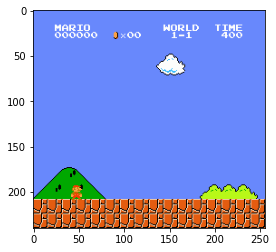

In [21]:
# Initialize Super Mario environment
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")
plt.imshow(next_state)

In [22]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        #bilinear resize
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

(4, 84, 84),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


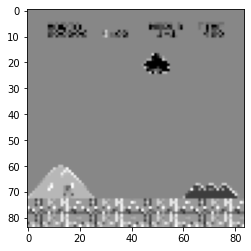

In [34]:
env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")
plt.imshow(next_state[0], cmap="Greys")

In [26]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir, exploration_rate_decay, save_every):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir
        self.net = MarioNet(self.state_dim, self.action_dim).float()

        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")

        self.exploration_rate = 1
        self.exploration_rate_decay = exploration_rate_decay
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = save_every  # no. of experiences between saving Mario Net

    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(LazyFrame): A single observation of the current state, dimension is (state_dim)
    Outputs:
    action_idx (int): An integer representing which action Mario will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state.__array__() #from lazy frame to array
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

In [27]:
#agent's memory
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir, exploration_rate_decay, save_every):
        super().__init__(state_dim, action_dim, save_dir, exploration_rate_decay, save_every)
        self.memory = deque(maxlen=100000)
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Each time Mario performs an action, he stores the experience to his memory. 
        His experience includes the current state, action performed, reward from the action, the next state, and whether the game is done.
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (LazyFrame),
        next_state (LazyFrame),
        action (int),
        reward (float),
        done(bool))
        """
        state = state.__array__()
        next_state = next_state.__array__()

        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = random.sample(self.memory, self.batch_size)
        # *batch: unpact batch to individual (s,s',a,r,d)
        # zip(): create an iteracble on unpacked batch
        # map(): apply torch.stack in each iterable
        # torch.stack: Concatenates a sequence of tensors along a new dimension.
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        # squeeze(): dimension 1 is removed
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

In [28]:
#DDQN: two ConvNets - online & target, that independently approximate the optimal action-value function.
#Both share the same nn struc but seperate (w,b)
#target does not back propagate to update (w,b). Periodically sync with online
class MarioNet(nn.Module):
    """mini cnn structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

In [29]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, exploration_rate_decay, save_every):
        super().__init__(state_dim, action_dim, save_dir, exploration_rate_decay, save_every)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        
        current_state_Q = self.net(state, model="online")#Q for (batch,action_space)
        current_Q = current_state_Q[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        
        return current_Q

    @torch.no_grad() #don’t need to backpropagate on target (w,b)
    def td_target(self, reward, next_state, done):
        #use online model to find a'
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        #use target model to find q(s',a')
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

In [30]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, exploration_rate_decay, save_every, learn_rate):
        super().__init__(state_dim, action_dim, save_dir, exploration_rate_decay, save_every)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=learn_rate)
        self.loss_fn = torch.nn.SmoothL1Loss() #mean reduction

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target) #loss between current and target TD
        self.optimizer.zero_grad() #reset grad on each weight to 0, otherwise accumulate on batch
        loss.backward() #compute loss grad wrt weights
        #theta <- theta + lr * Delta(TD_target-q(s,a))
        self.optimizer.step() #adjust weights by grad and learning rate
        return loss.item() #report loss

    def sync_Q_target(self):
        #periodically copy online weights to target model
        self.net.target.load_state_dict(self.net.online.state_dict())

In [31]:
#save checkpoint
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate), #exploration rate changing during training
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")
    def load(self,load_path):
        try:
            self.net.load_state_dict(torch.load(load_path)['model'])
            self.exploration_rate = torch.load(load_path)['exploration_rate']
        except:
            print(
                f"no weights are loaded as either {load_path} cannot be found or incompatible to current model.")
        else:
            print(f"weights are loaded successfuly! exploration_rate is {self.exploration_rate}")

In [32]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, exploration_rate_decay, save_every, learn_rate):
        super().__init__(state_dim, action_dim, save_dir, exploration_rate_decay, save_every, learn_rate)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory in batch
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate in batch
        td_est = self.td_estimate(state, action)

        # Get TD Target in batch
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

In [33]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

In [14]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir,exploration_rate_decay=0.99999975,save_every=2e5,learn_rate=0.00025)
mario.load("/Users/junhongchen/Documents/GitHub/deep_rl_exercise/pytorch_basic/mario/checkpoints/2022-03-12T00-31-11/mario_net_4.chkpt")

logger = MetricLogger(save_dir)

episodes = 4000
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if e % 20 == 0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

Using CUDA: False

weights are loaded successfuly! exploration_rate is 0.21224793265768857


/var/folders/6n/cgj1j5y91d591cjz0b83gx3r0000gn/T/ipykernel_99876/3067730520.py:35: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 0 - Step 576 - Epsilon 0.2122173711520427 - Mean Reward 2302.0 - Mean Length 576.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 7.118 - Time 2022-03-13T01:35:12
Episode 20 - Step 3807 - Epsilon 0.2120460217621031 - Mean Reward 901.095 - Mean Length 181.286 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 40.894 - Time 2022-03-13T01:35:53
Episode 40 - Step 9145 - Epsilon 0.21176323504208022 - Mean Reward 970.024 - Mean Length 223.049 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 57.692 - Time 2022-03-13T01:36:51
Episode 60 - Step 12088 - Epsilon 0.21160748752505176 - Mean Reward 899.82 - Mean Length 198.164 - Mean Loss 0.442 - Mean Q Value 9.267 - Time Delta 86.305 - Time 2022-03-13T01:38:17
Episode 80 - Step 16906 - Epsilon 0.21135275971507198 - Mean Reward 915.21 - Mean Length 208.716 - Mean Loss 0.679 - Mean Q Value 17.577 - Time Delta 174.137 - Time 2022-03-13T01:41:11
Episode 100 - Step 20634 - Epsilon 0.21115587068292016 - Mean Reward 893.02 - Mean Length 200.58 - Mean

<Figure size 432x288 with 0 Axes>